In [ ]:
# Import the required modules
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['font.size'] = 8
from skimage import img_as_float
from skimage import exposure
import plotly.graph_objects as go

import os
import glob
import random
from skimage import io # To preprocess the images
from distutils.file_util import copy_file
import seaborn as sns
import cv2
import keras
from keras.models import load_model
from keras import backend as K
import tensorflow as tf

from skimage.transform import rescale
from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import RMSprop

import seaborn as sns
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow
from tensorflow.keras.preprocessing.image import load_img, img_to_array,array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten

import warnings
warnings.simplefilter('ignore')

In [ ]:
from google.colab import files
import zipfile

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/X-RayCOVID19Detection-main/archive.zip", 'r')
zip_ref.extractall("/tmp/")
zip_ref.close()

In [ ]:
! ls /tmp/

COVID-19_Radiography_Dataset
dap_multiplexer.6bd1b7c9c20e.root.log.INFO.20220427-090529.56
dap_multiplexer.INFO
debugger_1isxlfqrtw
directoryprefetcher_binary.6bd1b7c9c20e.root.log.INFO.20220427-090900.287
directoryprefetcher_binary.6bd1b7c9c20e.root.log.INFO.20220427-091219.430
directoryprefetcher_binary.INFO
drivefs_ipc.0
drivefs_ipc.0_shell
initgoogle_syslog_dir.0
pyright-110-4TdSc2utrncO
pyright-110-qW4xAieNGY4V
python-languageserver-cancellation


In [ ]:
! ls /tmp/COVID-19_Radiography_Dataset/

 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		     'Viral Pneumonia'
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal


In [ ]:
DATASET_PATH = '/tmp/COVID-19_Radiography_Dataset'

In [ ]:
# We will divide the dataset into two classes
data_class = ['COVID', 'Normal', 'Viral Pneumonia']

In [ ]:
covid_positive_path = os.path.join(DATASET_PATH,data_class[0],'*')

In [ ]:
print(os.path.join(DATASET_PATH,data_class[2],'*'))

/tmp/COVID-19_Radiography_Dataset/Viral Pneumonia/*


In [ ]:
print(covid_positive_path)

/tmp/COVID-19_Radiography_Dataset/COVID/*


In [ ]:

#Just observing the images
#obs_path = os.path.join(covid_positive_path,'*.png')
#print(obs_path)
#data = glob.glob(obs_path)
#for file in data:
#  print(file)

Text(0.5, 1.0, 'Pneumonial Viral patient')

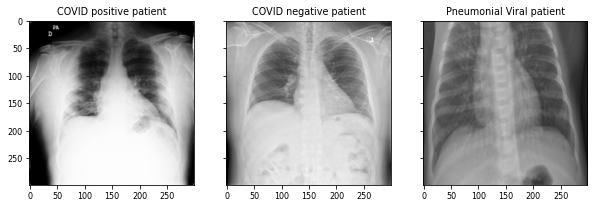

In [ ]:
covid = glob.glob(covid_positive_path)
covid = io.imread(covid[0])
#print(covid)
normal_path = os.path.join(DATASET_PATH,data_class[1],'*')
normal = glob.glob(normal_path)
normal = io.imread(normal[0],plugin='matplotlib')
viral_path = os.path.join(DATASET_PATH,data_class[2],'*')
viral = glob.glob(viral_path)
viral = io.imread(viral[0],plugin='matplotlib')

fig,(ax1,ax2,ax3) = plt.subplots(1,3, sharey='all')
fig.set_figwidth(10)
ax1.imshow(covid, cmap='gray')
ax1.set_title('COVID positive patient')

ax2.imshow(normal, cmap='gray')
ax2.set_title('COVID negative patient')

ax3.imshow(viral, cmap='gray')
ax3.set_title('Pneumonial Viral patient')

# **Print shape of the images**

In [ ]:
print(f'Image shape:{covid.shape}')
print(f'Number of COVID positive images:{len(os.listdir(covid_positive_path[:-2]))}')
print(f'Number of COVID negative images:{len(os.listdir(normal_path[:-2]))}')
print(f'Number of Pneumonial viral infection images:{len(os.listdir(viral_path[:-2]))}')

Image shape:(299, 299)
Number of COVID positive images:3616
Number of COVID negative images:10192
Number of Pneumonial viral infection images:1345


## **Preprocessing Images (Perfoeming Histogram Equalizatio)**

In [ ]:
def plot_img_and_hist(image, axes, bins=256):
  """Plot an image with its histogram and cumulutive histogram"""
  image = img_as_float(image)
  ax_img, ax_hist = axes
  print(axes.shape)
  ax_cdf = ax_hist.twinx()
  # Display image
  # Display image
  ax_img.imshow(image, cmap=plt.cm.gray)
  ax_img.set_axis_off()

  # Display histogram
  ax_hist.hist(image.ravel(), bins=bins, color='black')
  ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
  ax_hist.set_xlabel('Pixel intensity')
  ax_hist.set_xlim(0, 1)
  ax_hist.set_yticks([])

  # Display cumulative distribution
  img_cdf, bins = exposure.cumulative_distribution(image, bins)
  ax_cdf.plot(bins, img_cdf, 'r')
  ax_cdf.set_yticks([])

  return ax_img, ax_hist, ax_cdf


p2=0.0, p98 = 253.0
(2,)
(2,)
(2,)
(2,)


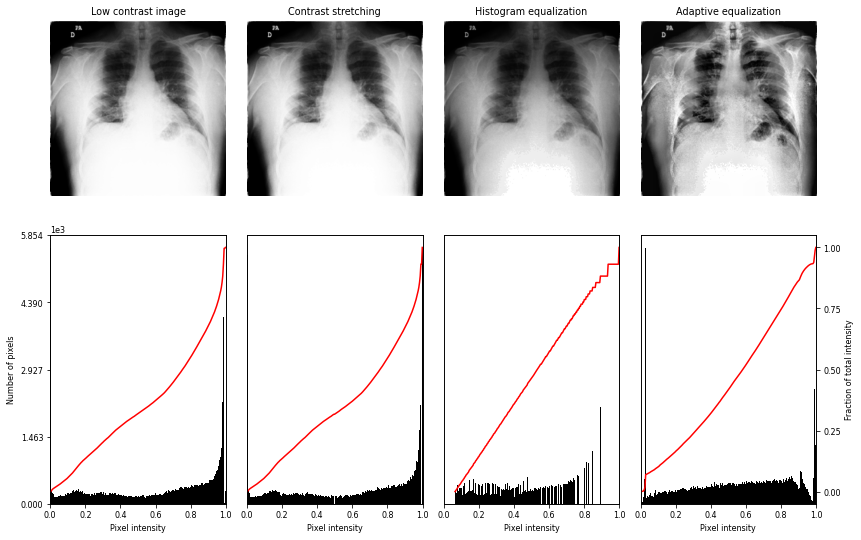

In [ ]:
# Loading the image here
#img = normal
img = covid
# Contrast stretching
p2, p98 = np.percentile(img,(2,98))
print(f'p2={p2}, p98 = {p98}')
img_rescale =exposure.rescale_intensity(img,(p2,p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equaliztion
img_adapteq = exposure.equalize_adapthist(img_eq, clip_limit=0.03)

#Display results
fig = plt.figure(figsize=(12,8))
axes = np.zeros((2,4), dtype=np.object)
#print(type(axes),axes.shape)
axes[0,0] = fig.add_subplot(2,4,1)

for i in range(1,4):
  axes[0,i] = fig.add_subplot(2,4,1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0,4):
  axes[1,i] = fig.add_subplot(2,4,5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:,0])
ax_img.set_title('Low contrast image')


y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))


ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()








## Creating train-test data

In [ ]:
# Create the list of paths to the images
Covid_Positive_List_Paths = []
Normal_List_Paths = []
Viral_List_Paths = []
# Get covid images files paths
for root, directories, files in os.walk(covid_positive_path[:-2]):
  for name in files:
    Covid_Positive_List_Paths.append(os.path.join(root,name))

for root, directories, files in os.walk(normal_path[:-2]):
  for name in files:
    Normal_List_Paths.append(os.path.join(root,name))

for root, directories, files in os.walk(viral_path[:-2]):
  for name in files:
    Viral_List_Paths.append(os.path.join(root,name))
    

In [ ]:
random.shuffle(Covid_Positive_List_Paths)
random.shuffle(Normal_List_Paths)
random.shuffle(Viral_List_Paths)

## **Split the data**

In [ ]:
#main data folder
!mkdir ./Data/

#train data folders
!mkdir ./Data/Train/
!mkdir ./Data/Train/Covid/
!mkdir ./Data/Train/Normal/
!mkdir ./Data/Train/Viral/

#test data folders
!mkdir ./Data/Test/
!mkdir ./Data/Test/Covid/
!mkdir ./Data/Test/Normal/
!mkdir ./Data/Test/Viral/

PathCovidTrain = './Data/Train/Covid/'
PathCovidTest = './Data/Test/Covid/'

PathNormalTrain = './Data/Train/Normal/'
PathNormalTest = './Data/Test/Normal/'

PathViralTrain = './Data/Train/Viral/'
PathViralTest = './Data/Test/Viral/'

num_covid = len(os.listdir(covid_positive_path[:-2]))
num_normal = len(os.listdir(normal_path[:-2]))
num_viral = len(os.listdir(viral_path[:-2]))

num_covid_train = round(len(os.listdir(covid_positive_path[:-2])) * 0.8)
num_normal_train = round(len(os.listdir(normal_path[:-2]))*0.8)
num_viral_train = round(len(os.listdir(viral_path[:-2]))*0.8)

for i in range(num_covid):
  if i < num_covid_train:
    copy_file(Covid_Positive_List_Paths[i],PathCovidTrain)
  else:
    copy_file(Covid_Positive_List_Paths[i],PathCovidTest)

for i in range(num_normal):
  if i < num_normal_train:
    copy_file(Normal_List_Paths[i],PathNormalTrain)
  else:
    copy_file(Normal_List_Paths[i],PathNormalTest)

for i in range(num_viral):
  if i < num_viral_train:
    copy_file(Viral_List_Paths[i],PathViralTrain)
  else:
    copy_file(Viral_List_Paths[i],PathViralTest)


mkdir: cannot create directory ‘./Data/’: File exists
mkdir: cannot create directory ‘./Data/Train/’: File exists
mkdir: cannot create directory ‘./Data/Train/Covid/’: File exists
mkdir: cannot create directory ‘./Data/Train/Normal/’: File exists
mkdir: cannot create directory ‘./Data/Train/Viral/’: File exists
mkdir: cannot create directory ‘./Data/Test/’: File exists
mkdir: cannot create directory ‘./Data/Test/Covid/’: File exists
mkdir: cannot create directory ‘./Data/Test/Normal/’: File exists
mkdir: cannot create directory ‘./Data/Test/Viral/’: File exists


Defin the data generator

In [ ]:
# Definition of data generators

# For training data
trainGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.2,
    shear_range = 0.2,
    featurewise_center =True,
    featurewise_std_normalization = True,
    width_shift_range = 0,
    vertical_flip = False,
    fill_mode = 'nearest'
) 
# Data for test
testGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

# Build data generators

In [ ]:
# Bulild for train data
pathTrainDir = './Data/Train'
trainGeneratorBulid = trainGenerator.flow_from_directory(
    pathTrainDir,
    target_size = (299,299),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle =True
)

#Build for test data
pathTestDir = './Data/Test'
testGeneratorBuild = testGenerator.flow_from_directory(
    pathTestDir,
    target_size = (299,299),
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
)

Found 12123 images belonging to 3 classes.
Found 3030 images belonging to 3 classes.


**Only to get Labels. Not to be used for training the module.**

In [ ]:
pathTestDir1 = './Data/Test'
testGeneratorBuild1 = testGenerator.flow_from_directory(
    pathTestDir,
    target_size = (299,299),
    class_mode = 'categorical',
    batch_size = 3030,
    shuffle = False
)

Found 3030 images belonging to 3 classes.


In [ ]:
#images, labels = trainGeneratorBulid.next()
testlabels = testGeneratorBuild1.labels

testlabels

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [ ]:
testlabels.shape


(3030,)

In [ ]:
#while(testGeneratorBuild.next()):
#  _,testlabels1=testGeneratorBuild.next()
#  np.append(testlabels, testlabels1,axis=0)

In [ ]:
#targetLabels= tf.argmax(testlabels,1)
#targetLabels=targetLabels.numpy()
#targetLabels.shape
#targetLabels[2]
targetLabels= testlabels
targetLabels.shape

(3030,)

### Simple CNN model

In [ ]:
#Using sequential model:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [ ]:
# Define our custom loss function

#def focal_loss(y_true, y_pred):
#    gamma = 2.0
#    alpha = 0.25
#    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


# Compile our model
#adam = tf.keras.optimizers.Adam(lr=0.0001)
#model.compile(loss=[focal_loss], metrics=["accuracy"], optimizer=adam)

adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"], optimizer=adam)


In [ ]:
targetLabels.shape

(3030,)

In [ ]:
start = datetime.datetime.now()

number_epochs = 15


history = model.fit(trainGeneratorBulid,
                    epochs = number_epochs, 
                    validation_data = testGeneratorBuild,
                    verbose = 1)

end = datetime.datetime.now()
print(f'Total Training Time: {end - start}')

Epoch 1/15
379/379 [==============================] - 299s 760ms/step - loss: 0.6174 - accuracy: 0.7266 - val_loss: 0.4232 - val_accuracy: 0.8314
Epoch 2/15
379/379 [==============================] - 285s 751ms/step - loss: 0.4648 - accuracy: 0.7942 - val_loss: 0.3976 - val_accuracy: 0.8333
Epoch 3/15
379/379 [==============================] - 288s 759ms/step - loss: 0.4083 - accuracy: 0.8240 - val_loss: 0.3152 - val_accuracy: 0.8799
Epoch 4/15
379/379 [==============================] - 283s 746ms/step - loss: 0.3664 - accuracy: 0.8441 - val_loss: 0.2789 - val_accuracy: 0.8941
Epoch 5/15
379/379 [==============================] - 284s 750ms/step - loss: 0.3327 - accuracy: 0.8593 - val_loss: 0.2917 - val_accuracy: 0.8901
Epoch 6/15
379/379 [==============================] - 285s 751ms/step - loss: 0.3101 - accuracy: 0.8736 - val_loss: 0.2271 - val_accuracy: 0.9145
Epoch 7/15
379/379 [==============================] - 285s 752ms/step - loss: 0.2990 - accuracy: 0.8763 - val_loss: 0.3061 -

True

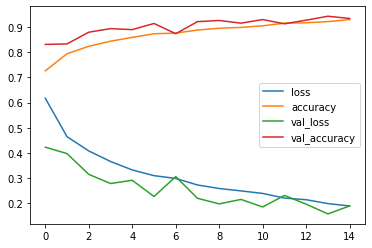

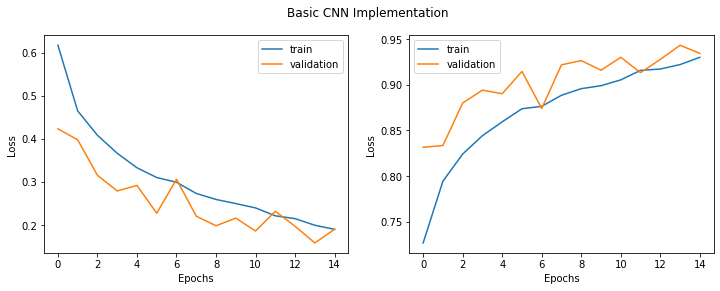

In [ ]:
pd.DataFrame(history.history).plot()
#Plot Training Loss vs Validation Loss
def plot_history(history,title_name):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle('{}'.format(title_name))
    ax1.plot(history.history['loss'],label='train')
    ax1.plot(history.history['val_loss'],label='validation_loss')
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.plot(history.history['accuracy'],label='train')
    ax2.plot(history.history['val_accuracy'],label='validation_accuracy')
    ax2.legend()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    return True
plot_history(history,'Basic CNN Implementation')

In [ ]:
model.save_weights('/content/gdrive/MyDrive/X-RayCOVID19Detection-main/RegularCNN_results.h5')
model.save('/content/gdrive/MyDrive/X-RayCOVID19Detection-main/RegularCNN_model.h5')

In [ ]:
hst= pd.DataFrame(history.history)
hst.head()
score= model.predict(testGeneratorBuild)


In [ ]:
score.shape

(3030, 3)

In [ ]:
#a= tf.argmax(score,1)
pred= tf.one_hot(tf.argmax(score,1), depth = 3)
pred = tf.argmax(pred,1).numpy()
pred


array([0, 0, 0, ..., 1, 2, 2])

In [ ]:
##Model Evaluation
tst_loss,tst_acc=model.evaluate(testGeneratorBuild)
print('CNN Model Test Loss: {}, Test Accuracy: {}'.format(tst_loss,tst_acc))

95/95 [==============================] - 12s 123ms/step - loss: 0.1899 - accuracy: 0.9343
CNN Model Test Loss: 0.18990279734134674, Test Accuracy: 0.9343234300613403


In [ ]:
from sklearn.metrics import f1_score

In [ ]:
##Model Evaluation
print(targetLabels)
targetLabels.shape

[0 0 0 ... 2 2 2]


(3030,)

In [ ]:
f1_score(targetLabels,pred, average='macro')

0.91399087463247

In [ ]:

from sklearn.metrics import classification_report
print(classification_report(pred,targetLabels))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88       616
           1       0.99      0.93      0.96      2170
           2       0.87      0.95      0.91       244

    accuracy                           0.93      3030
   macro avg       0.89      0.95      0.91      3030
weighted avg       0.94      0.93      0.94      3030



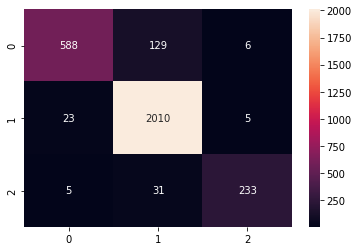

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(targetLabels,pred)
sns.heatmap(cm, annot=True, fmt="d")
#print(confusion_matrix(targetLabels,pred))

In [ ]:
#from google.colab import files
#files.download("RegularCNN_results.data-00000-of-00001")
#files.download(RegularCNN_results.index)

In [ ]:
#files.download("RegularCNN_results.index")

Now we will use ResNET model

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(
    include_top = False,

    weights = 'imagenet',
    input_shape = (299, 299, 3),
    classifier_activation = 'softmax'
    
)

219070464/219055592 [==============================] - 5s 0us/step


Create a model

In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(base_model.output)
out = tf.keras.layers.Dense(3, activation='softmax', name='dense_output')(x)
model_1 = tf.keras.models.Model(inputs = base_model.input, outputs=out)


1. Binary Cross_Entropy

In [ ]:
model_1.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [ ]:
# Fit Keras model
start = datetime.datetime.now()

model_1_history = model_1.fit_generator(
    # Use train generator
    trainGeneratorBulid,

    # Set epochs to 15
    epochs = 15,

    # Set steps per epochs to 300
    steps_per_epoch = 300,

    validation_data = testGeneratorBuild,
    
    # Set verbose to 1
    verbose = 1
)

end = datetime.datetime.now()
print(f'Total Training Time: {end - start}')

Epoch 1/15
300/300 [==============================] - 854s 3s/step - loss: 0.2041 - accuracy: 0.9274 - val_loss: 0.2278 - val_accuracy: 0.9211
Epoch 2/15
300/300 [==============================] - 805s 3s/step - loss: 0.1222 - accuracy: 0.9589 - val_loss: 0.3761 - val_accuracy: 0.8541
Epoch 3/15
300/300 [==============================] - 805s 3s/step - loss: 0.1034 - accuracy: 0.9633 - val_loss: 0.5556 - val_accuracy: 0.7891
Epoch 4/15
300/300 [==============================] - 805s 3s/step - loss: 0.0822 - accuracy: 0.9716 - val_loss: 0.5485 - val_accuracy: 0.8439
Epoch 5/15
300/300 [==============================] - 805s 3s/step - loss: 0.0801 - accuracy: 0.9719 - val_loss: 0.2046 - val_accuracy: 0.9320
Epoch 6/15
300/300 [==============================] - 804s 3s/step - loss: 0.0707 - accuracy: 0.9767 - val_loss: 0.1019 - val_accuracy: 0.9650
Epoch 7/15
300/300 [==============================] - 804s 3s/step - loss: 0.0617 - accuracy: 0.9792 - val_loss: 0.0744 - val_accuracy: 0.9749

In [ ]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

True

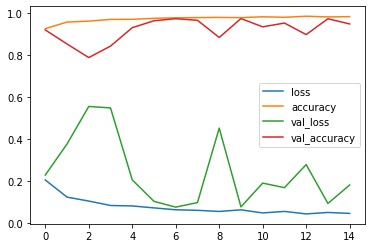

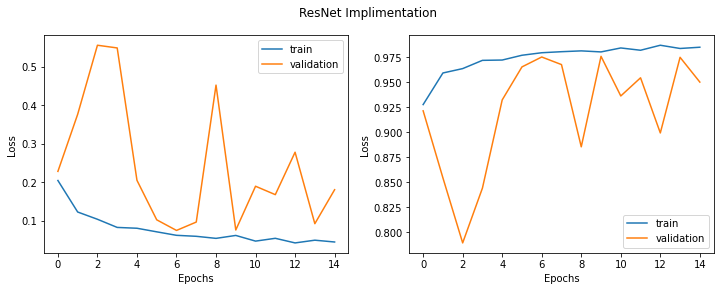

In [ ]:
pd.DataFrame(model_1_history.history).plot()
#Plot Training Loss vs Validation Loss
def plot_history(model_1_history,title_name):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle('{}'.format(title_name))
    ax1.plot(model_1_history.history['loss'],label='train')
    ax1.plot(model_1_history.history['val_loss'],label='validation_loss')
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.plot(model_1_history.history['accuracy'],label='train')
    ax2.plot(model_1_history.history['val_accuracy'],label='validation_accuracy')
    ax2.legend()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    return True
plot_history(model_1_history,'ResNet Implimentation')


In [ ]:
hst= pd.DataFrame(model_1_history.history)
hst.head()
score= model_1.predict(testGeneratorBuild)

In [ ]:
score.shape

(3030, 3)

In [ ]:
#a= tf.argmax(score,1)
pred= tf.one_hot(tf.argmax(score,1), depth = 3)
pred = tf.argmax(pred,1).numpy()
pred.shape

(3030,)

In [ ]:
##Model Evaluation
tst_loss,tst_acc=model_1.evaluate(testGeneratorBuild)
print('RESNET Model Test Loss: {}, Test Accuracy: {}'.format(tst_loss,tst_acc))

95/95 [==============================] - 69s 724ms/step - loss: 0.1802 - accuracy: 0.9498
RESNET Model Test Loss: 0.18018901348114014, Test Accuracy: 0.9498350024223328


In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(targetLabels,pred, average='macro')

0.9049027327765158

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(targetLabels,pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       723
           1       0.97      0.98      0.97      2038
           2       0.98      0.70      0.82       269

    accuracy                           0.95      3030
   macro avg       0.95      0.88      0.90      3030
weighted avg       0.95      0.95      0.95      3030



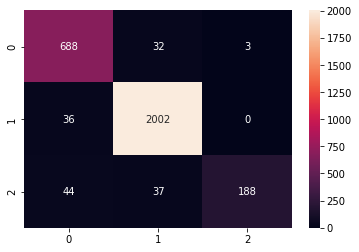

In [ ]:
# confusion matrix   0 1[0 1]

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(targetLabels,pred)
sns.heatmap(cm, annot=True, fmt="d")
#print(confusion_matrix(targetLabels,pred))

In [ ]:
model_1.save_weights('/content/gdrive/MyDrive/X-RayCOVID19Detection-main/RESNET_Results.h5')
model_1.save('/content/gdrive/MyDrive/X-RayCOVID19Detection-main/RESNET_model.h5')

In [ ]:
#from google.colab import files
#files.download("RESNET_Results.data-00000-of-00001")
#files.download(RESNET_Results.index)

In [ ]:
#files.download("RESNET_Results.index")

Vgg16 model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten
#from tensorflow.keras.backend import K

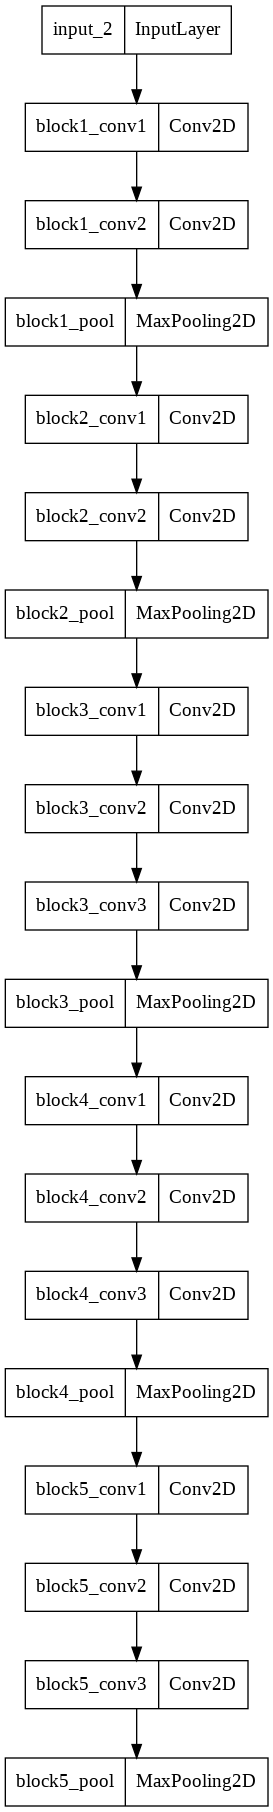

In [ ]:
vgg=VGG16(include_top=False,weights='imagenet',
         input_shape=(299, 299, 3))
plot_model(vgg,to_file='model.png')

In [ ]:
##Avoid training existing weights, otherwise existing weights will be overwrite
for layer in vgg.layers:
  layer.trainable=False

In [ ]:
x=Flatten()(vgg.output)
prediction_vgg=tf.keras.layers.Dense(3,activation='softmax')(x)

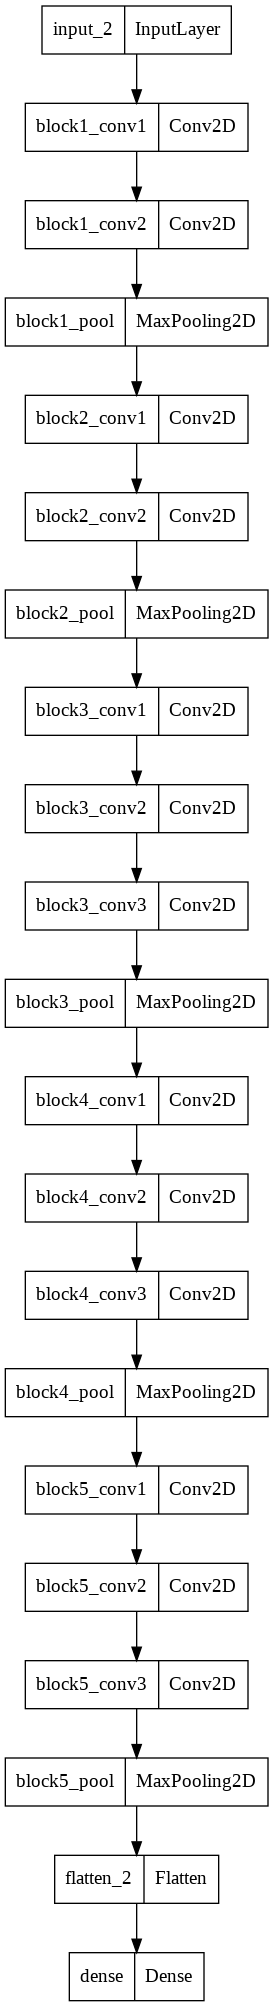

In [ ]:
##Create Inception Model
from tensorflow.keras.models import Model
vgg_model=Model(inputs=vgg.input,outputs=prediction_vgg)
plot_model(vgg_model)

In [ ]:
#vgg_model.trainable=False ##VGG-16 Freeze
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [ ]:
number_epochs= 15
vgg_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='CategoricalCrossentropy',
                  metrics=['accuracy'])
vgg_history=vgg_model.fit(trainGeneratorBulid,
                           validation_data = testGeneratorBuild,
                           #batch_size=10,
                           steps_per_epoch=300,
                           #validation_steps=val_data.samples//batch_size,
                           epochs=number_epochs,
                           verbose = 1 )
#model_vgg.save('model_vgg.h5')

Epoch 1/15
255/300 [========================>.....] - ETA: 21:08 - loss: 1.2228 - accuracy: 0.7452

In [ ]:
#plot_history(vgg_history.history,'VGG Model with Image Augmentation')
pd.DataFrame(vgg_history.history).plot()
#Plot Training Loss vs Validation Loss
def plot_history(vgg_history,title_name):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle('{}'.format(title_name))
    ax1.plot(vgg_history.history['loss'],label='train')
    ax1.plot(vgg_history.history['val_loss'],label='validation_loss')
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.plot(vgg_history.history['accuracy'],label='train')
    ax2.plot(vgg_history.history['val_accuracy'],label='validation_accuracy')
    ax2.legend()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    return True
plot_history(vgg_history,'VGG Implimentation')

In [ ]:
res = pd.DataFrame(vgg_history.history)
res

In [ ]:
import pandas as pd
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

In [ ]:
##Model Evaluation
tst_loss,tst_acc=vgg_model.evaluate(testGeneratorBuild)
print('VGG16 Model Test Loss: {}, Test Accuracy: {}'.format(tst_loss,tst_acc))

In [ ]:
hst= pd.DataFrame(vgg_history.history)
hst.head()
score= vgg_model.predict(testGeneratorBuild)

In [ ]:
score.shape

In [ ]:
#a= tf.argmax(score,1)
pred= tf.one_hot(tf.argmax(score,1), depth = 3)
pred = tf.argmax(pred,1).numpy()
pred.shape

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(targetLabels,pred, average='macro')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(targetLabels,pred))

In [ ]:
# confusion matrix   0 1[0 1]

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(targetLabels,pred)
sns.heatmap(cm, annot=True, fmt="d")
#print(confusion_matrix(targetLabels,pred))

In [ ]:
vgg_model.save_weights('/content/gdrive/MyDrive/X-RayCOVID19Detection-main/VGG-16_Results.h5')
vgg_model.save('/content/gdrive/MyDrive/X-RayCOVID19Detection-main/VGG-16_model.h5')

In [ ]:
#from google.colab import files
#files.download("VGG-16_Results.data-00000-of-00001")
#files.download(VGG-16_Results.index)

In [ ]:
#files.download("VGG-16_Results.index")

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
uploaded = files.upload()
for filename in uploaded.keys():
  img_path = '/content/'+filename
  img = image.load_img(img_path,target_size=(299,299))
  images = image.img_to_array(img)
  images = np.expand_dims(images,axis=0)
  #prediction = model.predict(images)
  #prediction = model_1.predict(images)
  prediction = vgg_model.predict(images)
  print(filename)
 # print(prediction)
  i =  np.argmax(prediction)
  #print(i)
  print(data_class[i])

  #if prediction == 0:
  #  print('covid detected')
  #else:
   # print('Your report is normal')